# Import Statements

### Install newest version of seaborn
Run this cell and then restart runtime for this to take effect

In [4]:
!pip install git+https://github.com/mwaskom/seaborn.git

  Cloning https://github.com/mwaskom/seaborn.git to /tmp/pip-req-build-gqmhfl55
  Running setup.py bdist_wheel for seaborn ... - \ done
  Stored in directory: /tmp/pip-ephem-wheel-cache-3shoyx4h/wheels/4e/57/af/138c7bf2390a67f7010588cf080fb8b4e741bb290c2ad12018
Successfully built seaborn


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

from google.colab import files

print(sns.__version__)

0.9.0


**Questions**

1. Is there a correlation between budget and profit? **Yishu**
    a) Correlation for companies? ** Jackson **
2. What are the genres of movies are the most popular? The ones that make the most profit? - How has this changed over the years - **Jackson and Diyar**
3. What month is the best time to release movies? (earn the most profit) **Yishu**
5. What production comapnies make the most money (profit)?  **Jackson**
6. Has the profit of "based on novel" movies increased with recent influx of superhero movies? **Diyar**
7. Is there any correlation between genre and runtime? Are certain genres consistently longer than others? **Yishu**
8. Is there any correlation between runtime and vote average? is there an optimal runtime? ** Jackson**

        a) Is the correlation between runtime and vote average actually just because larger budgets are associated with longer runtimes and the budget is what makes the movie better?


In [3]:
movies = files.upload()

Saving tmdb_5000_movies.csv to tmdb_5000_movies.csv


In [4]:
movies_df = pd.read_csv("tmdb_5000_movies.csv")

#missing data (https://www.kaggle.com/tanetboss/how-to-get-high-rating-on-play-store)
total = movies_df.isnull().sum().sort_values(ascending=False)
percent = (movies_df.isnull().sum()/movies_df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data

# We don't do what is done in the kaggle kernel where the above was found as all the data we need is nearly completely clean
# the two cases for runtime are handled when neccesary as well as the one case with release_date

,Total,Percent
homepage,3091,0.643556
tagline,844,0.175724
overview,3,0.000625
runtime,2,0.000416
release_date,1,0.000208
vote_count,0,0.000000
genres,0,0.000000
id,0,0.000000
keywords,0,0.000000
original_language,0,0.000000


# Organizing the Data

### Helper Functions

In [0]:
# Extracts the year (as an int) from the string of YYYY-MM-DD
def extract_year(date_str):
  try:
    return int(date_str[0:4])
  except TypeError:
    return 0

# Extracts the month
def extract_month(date_str):
  try:
    return int(date_str[5:7])
  except TypeError:
    return 0

# The companies provided are given as a dict with unneccesary information (in string form). 
# Converts this string to a usable list
def list_from_dicts(list_dicts): 
  names = []
  list_dicts = json.loads(list_dicts)
  for d in list_dicts:
    names.append(d["name"])
  return names

# Finds the budget, revenue, and profit by each movie company
def find_bud_rev_pro(row, comp_list, curr_bud_list, curr_rev_list, curr_pro_list, curr_num_list, curr_first_years):
  # Adds the revenue, budget, and profit of the current row (associated with movie) to the proper list index only if the data is available for both revenue and budget
  for company in row["production_company_names"]:  
    if(row["revenue"] != 0 and row["budget"] != 0):
      curr_rev_list[comp_list == company] += row["revenue"]
      curr_bud_list[comp_list == company] += row["budget"]
      curr_pro_list[comp_list == company] += row["profit"]
      curr_num_list[comp_list == company] += 1
      if curr_first_years[comp_list == company] == 0:
        curr_first_years[comp_list == company] = row["release_year"]
      elif curr_first_years[comp_list == company] > row["release_year"]:
        curr_first_years[comp_list == company] = row["release_year"]

# Puts produciton companies into 4 groups based on number of movies they've been involved with
def categorize_num_movies(val):
  if val <= 50:
    return "<50"
  elif val <= 100: 
    return "51-100";
  elif val <= 150:
    return "101-150";
  elif val <= 200:
    return "151-200"
  elif val <= 250:
    return "201-250"
  elif val <= 300:
    return "251-300"
  else:
    return ">300"
  
# Finds the most made type of movie that year (Might be overkill since it's only two lines)
def max_by_year(row):
  sums = row[1:-1]
  return sums.idxmax()

### New Columns

In [0]:
# Profit
movies_df['profit'] = movies_df['revenue'] - movies_df['budget']

# Release Date as a DateTime object
movies_df["release_date_timeseries"] = pd.to_datetime(movies_df["release_date"])

# Studio name column (creates list of all production companies that worked on this movie)
movies_df["production_company_names"] = movies_df["production_companies"].apply(list_from_dicts)

# Genre columns (creates list of all the genres that this movie exists as)
movies_df["genre_list"] = movies_df["genres"].apply(list_from_dicts)

# Release year (Removes a movie with no release_date or other information)
movies_df["release_year"] = movies_df["release_date"].apply(extract_year)
movies_df = movies_df[movies_df["release_year"] != 0]

# Release month
movies_df["release_month"] = movies_df["release_date"].apply(extract_month)

### New DataFrames

In [0]:
# New DataFrame: English movies only

english_movies_df = movies_df[movies_df["original_language"] == "en"]


In [0]:
# New DataFrame: Columns for company names, revenue, budget, profit, and number of movies made

# Problem 1: Need to decide how to handle movies that have only budget information or only revenue information entered
# Solution 1: Ended up just not adding the numbers to revenue, budget and profit if revenue or budget was equal to 0

# Problem 2: We can add the list of movies if we want but it isn't easy to do and we can't really plot anything with it. We can probably safely ignore it. 
# Solution 2: Really didn't wanna work so I just skipped it. 

# Problem 3: The apply() function that creates the new lists for company_df is crazy slow. 
# Possible solution: Rather than put them into these lists it might be better to just add columns to the dataframe. That's probably much faster

# This is a list of the company lists tied to each movie. Set is used to remove duplicates
list_of_list_of_companies = [x for x in movies_df["production_company_names"]]
set_of_companies = set([individual for list_temp in list_of_list_of_companies for individual in list_temp])

# Converting to a np.array will make it easier to find corresponding index of other columns
np_list_of_companies = np.array(list(set_of_companies))

# Creates all the np.arrays that will represent the columns of the new dataframe 
size_of_columns = len(np_list_of_companies)
np_total_revenue_by_company = np.zeros(size_of_columns, dtype=int)
np_total_budget_by_company = np.zeros(size_of_columns, dtype=int)
np_total_profit_by_company = np.zeros(size_of_columns, dtype=int)
np_number_of_movies_by_company = np.zeros(size_of_columns, dtype=int)
np_first_year = np.zeros(size_of_columns, dtype=int)

# This is crazy slow but don't really know how to make it better
movies_df.apply(find_bud_rev_pro, args=(np_list_of_companies, np_total_budget_by_company, np_total_revenue_by_company, np_total_profit_by_company, np_number_of_movies_by_company, np_first_year), axis=1)

# Creating the final company dataframe
columns = [("name", np_list_of_companies), ("revenue", np_total_revenue_by_company), ("budget", np_total_budget_by_company), ("profit", np_total_profit_by_company), ("num_movies", np_number_of_movies_by_company), ("first_year", np_first_year)]
company_df = pd.DataFrame.from_items(columns)
# Make number of movies category for hue in plot
company_df["num_movies_cat"] = company_df["num_movies"].apply(categorize_num_movies)
# Removes companies who made nothing
company_df = company_df[company_df["profit"] != 0]
# Sorts remaining entries (so the hue table is in order)
company_df = company_df.sort_values(by=["num_movies"])

In [100]:
company_df

,name,revenue,budget,profit,num_movies,first_year,num_movies_cat
0,Q&Q Medien GmbH,27053815,40000000,-12946185,1,2001,<50
2980,Rimfire Films,328203506,5000000,323203506,1,1986,<50
2984,Magna Global Entertainment,45000,3300000,-3255000,1,2014,<50
2985,Phoenix Film Poland,10700000,2159280,8540720,1,2013,<50
2987,Hachette Première,15000000,35000000,-20000000,1,1995,<50
2988,Helena Productions,497409852,175000000,322409852,1,2004,<50
2991,Famous Players Ltd,2120439,5952000,-3831561,1,1983,<50
2992,Rational Packaging Company,106371651,41300000,65071651,1,2000,<50
2994,MavroCine Pictures GmbH & Co. KG,385680446,150000000,235680446,1,2009,<50
2979,MMC Studios,9366227,23000000,-13633773,1,2009,<50


In [0]:
# New DataFrame: Movies with runtimes from 1 hour to 3 hours and have greater than zero votes
# These are worth looking into because in these time periods there's a pretty strong correlation between runtime and vote average

one_to_three_hours = movies_df[(movies_df["runtime"] > 60) & (movies_df["runtime"] < 180) & (movies_df["vote_count"] > 0)].sort_values(by="runtime")

In [0]:
# New DataFrame: Genre popularity organized by release_year. Columsn for release_year and count of movies by genre

# This is a list of the genre lists tied to each movie. Set is used to remove duplicates before being converted to a single list
list_of_list_of_genres = [x for x in movies_df["genre_list"]]
set_of_genres = set([individual for list_temp in list_of_list_of_genres for individual in list_temp])
list_of_genres = list(set_of_genres)

release_years = list(set(movies_df["release_year"]))
genres_df = pd.DataFrame({"release_year": release_years}).sort_values(by="release_year")

genres_df = genres_df.reindex(genres_df.columns.tolist() + list_of_genres, axis=1, fill_value=0)

count = int(0)
for checking_year in genres_df["release_year"]:
  to_check_df = movies_df[movies_df["release_year"] == checking_year]
  genre_lists_series = to_check_df["genre_list"]
  genre_list = np.array([genre for genre_list in genre_lists_series for genre in genre_list])
  unique, counts = np.unique(genre_list, return_counts=True)
  count_dict = dict(zip(unique, counts))
  for key, value in count_dict.items():
    genres_df.loc[count, key] = genres_df.loc[count, key] + int(value)
  count+=1
  
genres_df["favorite_genre"] = genres_df.apply(max_by_year, axis=1)

# Plots

### Question 1 & 4: Top 5 companies who've made the most money

[[1.         0.96278196]
 [0.96278196 1.        ]]


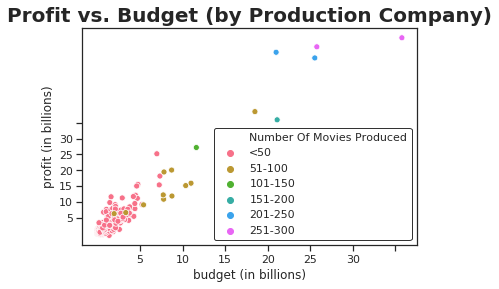

In [103]:
sns.set(style="ticks", color_codes=True)
xTicks = [(x / 4) * 10**9 for x in range(10, 80, 10)] 
yTicks = [(x / 2) * 10**9 for x in range(10, 70, 10)] 
xLabels = ["2.5", "5.0", "7.5", "10", "12.5", "15.0", "17.5"]
yLabels = ["5", "10", "15", "20", "25", "30"]

g = sns.scatterplot(x="budget", y="profit", hue="num_movies_cat", data=company_df, palette="husl")
t = g.set_title("Profit vs. Budget (by Production Company)", fontdict={"fontsize":20, "fontweight":"bold"})
x = g.set_xlabel("budget (in billions)")
x = g.set_ylabel("profit (in billions)")
a = g.set(xticks=xTicks, yticks=xTicks, xticklabels=yLabels, yticklabels=yLabels)
legend = g.legend(edgecolor="black")
legend.get_texts()[0].set_text("Number Of Movies Produced")
# Will not work if the ranges of movies produced changes

print(np.corrcoef(company_df["profit"], company_df["budget"]))

In [115]:
richest_companies = company_df.sort_values(by="profit").tail(10)
richest_companies
for company in richest_companies.itertuples():
  print(getattr(company, "name") + " made " + '${:,.2f}'.format(getattr(company, "profit")) + " starting in " + str(getattr(company, "first_year")))

Dune Entertainment made $9,728,281,204.00 starting in 2006
DreamWorks SKG made $10,032,033,626.00 starting in 1997
Amblin Entertainment made $12,605,035,147.00 starting in 1982
New Line Cinema made $13,593,525,592.00 starting in 1974
Columbia Pictures made $17,971,759,867.00 starting in 1938
Walt Disney Pictures made $19,266,982,158.00 starting in 1940
Paramount Pictures made $27,748,862,805.00 starting in 1927
Twentieth Century Fox Film Corporation made $28,642,711,776.00 starting in 1938
Universal Pictures made $29,509,237,061.00 starting in 1960
Warner Bros. made $30,938,380,614.00 starting in 1933


### Question 7: Correlation between runtime and vote average

array([[1.        , 0.37586541],
       [0.37586541, 1.        ]])

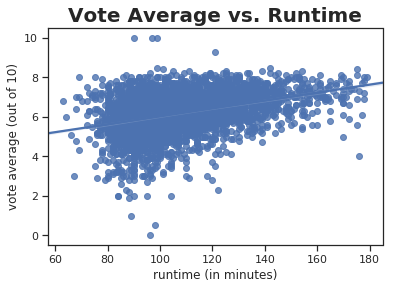

In [105]:
g = sns.regplot(x="runtime", y="vote_average", data=one_to_three_hours)
t = g.set_title("Vote Average vs. Runtime", fontdict={"fontsize":20, "fontweight":"bold"})
x = g.set_xlabel("runtime (in minutes)")
x = g.set_ylabel("vote average (out of 10)")

np.corrcoef(one_to_three_hours["runtime"], one_to_three_hours["vote_average"])
# Interesting that it has a really bad correlation coefficient but increaes in central tendency is so clear

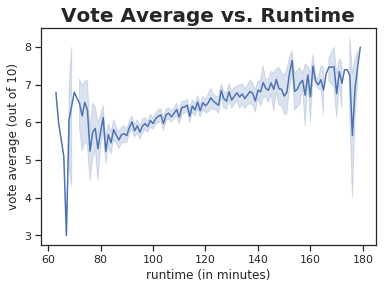

In [106]:
# Shows central tendency and confidence interval
g = sns.lineplot(x="runtime", y="vote_average", data=one_to_three_hours)
t = g.set_title("Vote Average vs. Runtime", fontdict={"fontsize":20, "fontweight":"bold"})
x = g.set_xlabel("runtime (in minutes)")
x = g.set_ylabel("vote average (out of 10)")

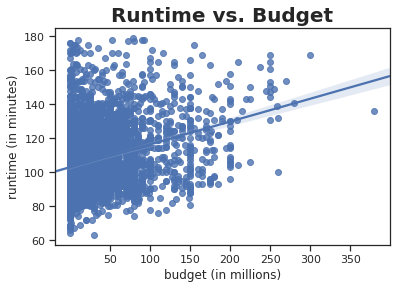

In [107]:
budgetTicks = [(x / 2) * 10**8 for x in range(1, 8)]
budgetLabels = ["50", "100", "150", "200", "250", "300", "350"]

g = sns.regplot(x="budget", y="runtime", data=one_to_three_hours)
t = g.set_title("Runtime vs. Budget", fontdict={"fontsize":20, "fontweight":"bold"})
x = g.set_xlabel("budget (in millions)")
x = g.set_ylabel("runtime (in minutes)")
x = g.set(xticks=budgetTicks, xticklabels=budgetLabels)

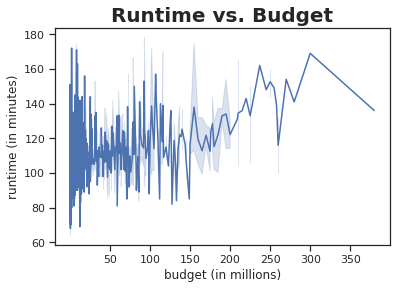

In [108]:
g = sns.lineplot(x="budget", y="runtime", data=one_to_three_hours)
t = g.set_title("Runtime vs. Budget", fontdict={"fontsize":20, "fontweight":"bold"})
x = g.set_xlabel("budget (in millions)")
x = g.set_ylabel("runtime (in minutes)")
x = g.set(xticks=budgetTicks, xticklabels=budgetLabels)

### Question 2: Most popular genres by year

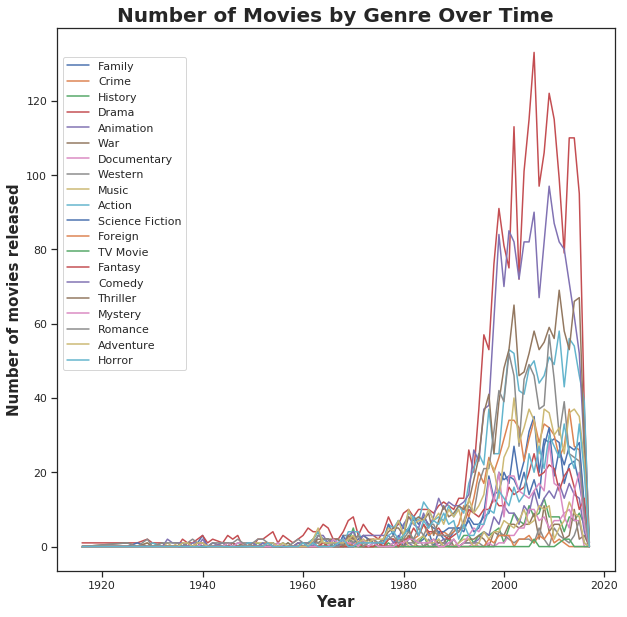

In [109]:
x1 = genres_df[genres_df["release_year"] < 1980]
x2 = genres_df[genres_df["release_year"] > 1980]

#figure1, ax = plt.subplots(1,4)
figure1 = plt.figure(figsize=(10,10))

for index in range(0,20):
  x = plt.plot("release_year", list_of_genres[index], data=genres_df)
l = figure1.legend(loc=(0.1,0.4))
t = plt.title("Number of Movies by Genre Over Time", fontdict={"fontsize":20, "fontweight":"bold"})
x = plt.xlabel("Year", fontdict={"fontsize":15, "fontweight":"bold"})
x = plt.ylabel("Number of movies released", fontdict={"fontsize":15, "fontweight":"bold"})

In [110]:
overall_favorite_genres = genres_df["favorite_genre"].value_counts()
for genre in overall_favorite_genres.keys():
  print(genre + " was the most popular genre " + str(overall_favorite_genres[genre]) + " times.")

  

Drama was the most popular genre 65 times.
Comedy was the most popular genre 9 times.
Action was the most popular genre 4 times.
Crime was the most popular genre 3 times.
Family was the most popular genre 3 times.
History was the most popular genre 2 times.
Music was the most popular genre 1 times.
Romance was the most popular genre 1 times.
Western was the most popular genre 1 times.
Adventure was the most popular genre 1 times.


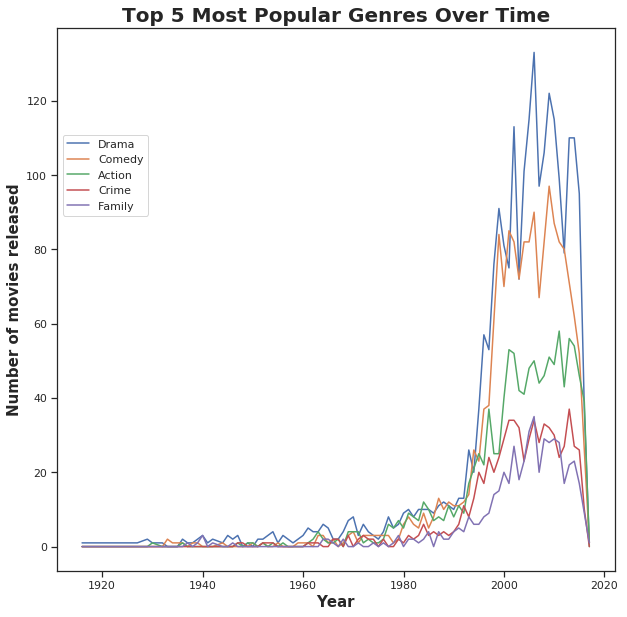

In [112]:
#figure1, ax = plt.subplots(1,4)
figure2 = plt.figure(figsize=(10,10))

for genre,val in overall_favorite_genres.items():
  if val > 2:
    x = plt.plot("release_year", genre, data=genres_df)
l = figure2.legend(loc=(0.1,0.65))
t = plt.title("Top 5 Most Popular Genres Over Time", fontdict={"fontsize":20, "fontweight":"bold"})
x = plt.xlabel("Year", fontdict={"fontsize":15, "fontweight":"bold"})
x = plt.ylabel("Number of movies released", fontdict={"fontsize":15, "fontweight":"bold"})

## **Budget vs. Profit**

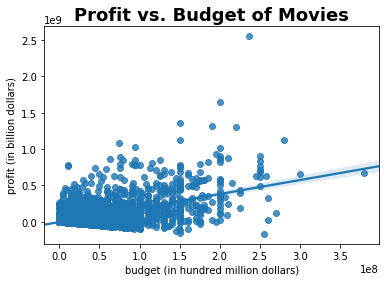

In [11]:
plot = sns.regplot(x = "budget", y = "profit", data = movies_df)
plot.set_xlabel("budget (in hundred million dollars)")
plot.set_ylabel("profit (in billion dollars)")
plot.set_title("Profit vs. Budget of Movies", weight='bold').set_fontsize('18')


In [12]:
np.corrcoef(movies_df['budget'], movies_df['profit'])
# corr coef of 0.578 which is not too bad, a moderate correlation between the two 

array([[1.        , 0.57583376],
       [0.57583376, 1.        ]])

In [13]:
movies_df.sort_values('budget').tail()
# movies that made the highest and lowest profit have about the same budget of 250 million 
# highest profitable movie is Avatar (outlier)
# movie with the highest budget is "Pirates of the Caribbean: On Stranger Tides" but the profit isn't the greatest

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,tagline,title,vote_average,vote_count,profit,release_date_timeseries,production_company_names,genre_list,release_year,release_month
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]",...,"Lost in our world, found in another.",John Carter,6.1,2124,24139100,2012-03-07,[Walt Disney Pictures],"[Action, Adventure, Science Fiction]",2012,3
10,270000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://www.superman.com,1452,"[{""id"": 83, ""name"": ""saving the world""}, {""id""...",en,Superman Returns,Superman returns to discover his 5-year absenc...,57.925623,"[{""name"": ""DC Comics"", ""id"": 429}, {""name"": ""L...",...,NaN,Superman Returns,5.4,1400,121081192,2006-06-28,"[DC Comics, Legendary Pictures, Warner Bros., ...","[Adventure, Fantasy, Action, Science Fiction]",2006,6
7,280000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://marvel.com/movies/movie/193/avengers_ag...,99861,"[{""id"": 8828, ""name"": ""marvel comic""}, {""id"": ...",en,Avengers: Age of Ultron,When Tony Stark tries to jumpstart a dormant p...,134.279229,"[{""name"": ""Marvel Studios"", ""id"": 420}, {""name...",...,A New Age Has Come.,Avengers: Age of Ultron,7.3,6767,1125403694,2015-04-22,"[Marvel Studios, Prime Focus, Revolution Sun S...","[Action, Adventure, Science Fiction]",2015,4
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...",...,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,661000000,2007-05-19,"[Walt Disney Pictures, Jerry Bruckheimer Films...","[Adventure, Fantasy, Action]",2007,5
17,380000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 28, ""...",http://disney.go.com/pirates/index-on-stranger...,1865,"[{""id"": 658, ""name"": ""sea""}, {""id"": 1316, ""nam...",en,Pirates of the Caribbean: On Stranger Tides,Captain Jack Sparrow crosses paths with a woma...,135.413856,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...",...,Live Forever Or Die Trying.,Pirates of the Caribbean: On Stranger Tides,6.4,4948,665713802,2011-05-14,"[Walt Disney Pictures, Jerry Bruckheimer Films...","[Adventure, Action, Fantasy]",2011,5


## **Most Profitable Time**


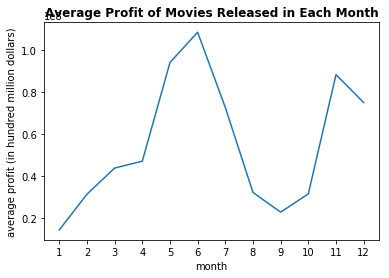

In [14]:
pf = movies_df.groupby('release_month')['profit'].mean()
pf = pf.tolist()
numbers = [x for x in range(1, 13)]
s = sns.lineplot(numbers, pf)
s.set(xticks=numbers)
s.set_xlabel("month")
s.set_ylabel("average profit (in hundred million dollars)")
s.set_title("Average Profit of Movies Released in Each Month", weight="bold").set_fontsize('12')

# June has the highest average profit, May/November are next best, January/September are the worst

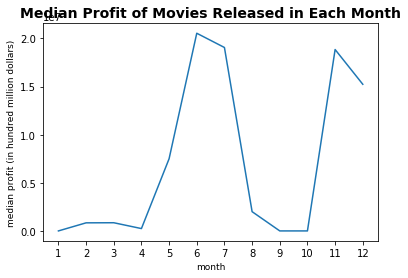

In [15]:
pf = movies_df.groupby('release_month')['profit'].median()
pf = pf.tolist()
numbers = [x for x in range(1, 13)]
s = sns.lineplot(numbers, pf)
s.set(xticks=numbers)
s.set_xlabel("month").set_fontsize('9')
s.set_ylabel("median profit (in hundred million dollars)").set_fontsize('9')
s.set_title("Median Profit of Movies Released in Each Month", weight="bold").set_fontsize('14')

## **Runtime vs. Genre**

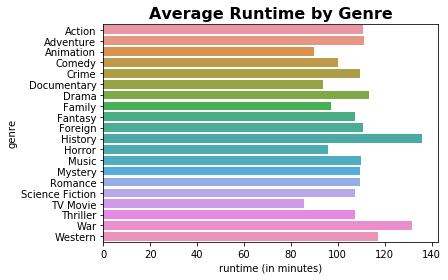

In [16]:
subset_df = movies_df[['runtime', 'genre_list']]
separated_df = pd.DataFrame({'runtime':np.repeat(subset_df.runtime.values, subset_df.genre_list.str.len()),
                        'genre_list':np.concatenate(subset_df.genre_list.values)})
separated_df
genres_runtime = separated_df.groupby('genre_list')['runtime'].mean()
genres_runtime2 = genres_runtime.tolist()
genres_runtime2
genres_runtime
genres = ['Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'Foreign', 
'History', 'Horror', 'Music', 'Mystery', 'Romance', 'Science Fiction', 'TV Movie', 'Thriller', 'War', 'Western']
bar_plot = sns.barplot(genres_runtime2, genres)
bar_plot.set_xlabel('runtime (in minutes)')
bar_plot.set_ylabel('genre')
bar_plot.set_title('Average Runtime by Genre', weight='bold').set_fontsize('16')

# Based on Novel vs Release Date

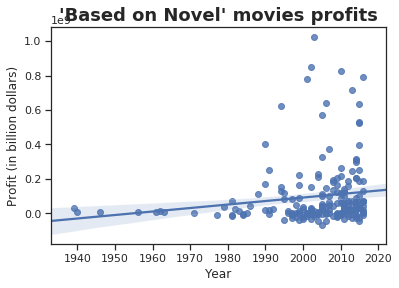

In [28]:
#let x = year and y= profit
lst=[]
lst2=[]
lst3=[]
lst4=[]
count=0
for a in movies_df["keywords"]:
  count+=1
  if "based on novel" in a:
    lst.append(count-1)

for b in lst:
  c = movies_df.iloc[[b]]
  d = c["budget"]
  e = c["revenue"]
  d = int(d)
  e = int(e)
  f = c["release_date"]
  g = str(f)
  h = g[5:12]
  h = h.strip()
  h = h[0:4]
  h = int(h)
  y = e-d
  x = h
  z = {"year":x, "profit":y}
  lst2.append(z)
  lst3.append(x)
  lst4.append(y)
#print(lst2)
#print(lst3)
#print(lst4)
import csv


df2 = pd.DataFrame(lst2)
df2.head()

plot = sns.regplot(x = "year", y = "profit", data = df2)
plot.set_xlabel("Year")
plot.set_ylabel("Profit (in billion dollars)")
plot.set_title("'Based on Novel' movies profits", weight='bold').set_fontsize('18')

# Where are movies produced most?

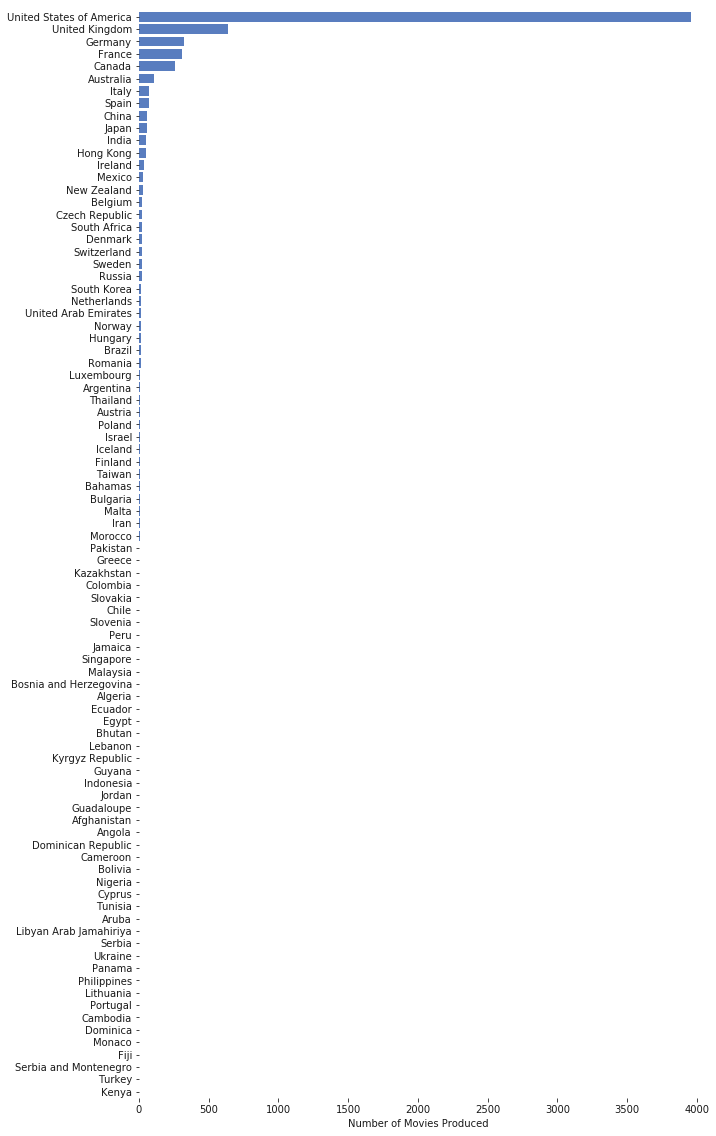

In [8]:
def list_from_dicts(list_dicts): 
  names = []
  list_dicts = json.loads(list_dicts)
  for d in list_dicts:
    names.append(d["name"])
  return names
movies_df["countries"] = movies_df["production_countries"].apply(list_from_dicts)
w= movies_df["countries"]

lst5 = []

df3 = pd.DataFrame(w)
df3.tail()

for i in list(df3.countries):
  for v in i:
    n = v
    lst5.append(v)

from collections import Counter
s = Counter(lst5)

l = list(s.items())

df4 = pd.DataFrame(l)
df4.head()

df4 = df4.sort_values(1, ascending=False)


f, ax = plt.subplots(figsize=(10, 20))


sns.set_color_codes("muted")
sns.barplot(x=1, y=0, data=df4, color="b")

ax.set(xlim=(0, 4000), ylabel="",
       xlabel="Number of Movies Produced")
sns.despine(left=True, bottom=True)

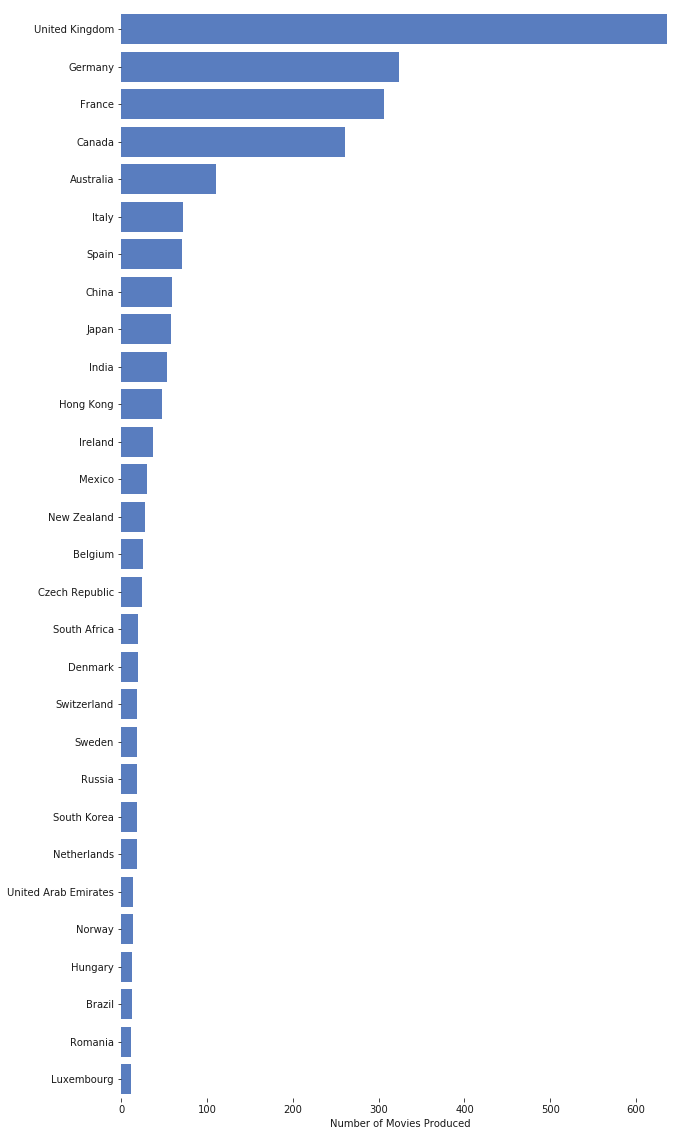

In [9]:
def list_from_dicts(list_dicts): 
  names = []
  list_dicts = json.loads(list_dicts)
  for d in list_dicts:
    names.append(d["name"])
  return names
movies_df["countries"] = movies_df["production_countries"].apply(list_from_dicts)
w= movies_df["countries"]

lst5 = []

df3 = pd.DataFrame(w)
df3.tail()

for i in list(df3.countries):
  for v in i:
    n = v
    lst5.append(v)

from collections import Counter
s = Counter(lst5)

l = list(s.items())

df4 = pd.DataFrame(l)
df4.head()

df4=df4.sort_values(1, ascending=False)

df5=df4.drop(df4.index[[0,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87]])

f, ax = plt.subplots(figsize=(10, 20))


sns.set_color_codes("muted")
sns.barplot(x=1, y=0, data=df5, color="b")

ax.set(xlim=(0, 650), ylabel="",
       xlabel="Number of Movies Produced")
sns.despine(left=True, bottom=True)